In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Section 1: Preprocess Data

Fraction of participants: 0.40


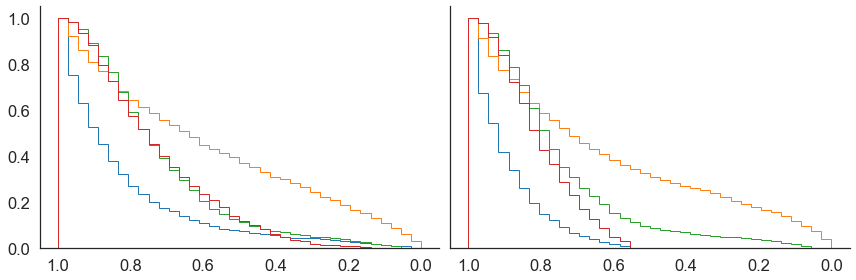

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
data = read_csv('data.csv').query('Study=="2018moutoussis"')

## Reduce to participants at both sessions.
data = data.groupby('Subject').filter(lambda x: x.Condition.nunique()==2)

## Compute accuracy within participants & sessions.
pre = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
pre['Cue'] = pre.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

## Compute fraction of participants with at least one bad session.
pivot = pre.pivot_table(index=('Subject','Condition'), columns='Cue', values='Accuracy')
pivot['R1'] = pivot['GW'] < 0.55
pivot['R2'] = pivot['NGAL'] < 0.55
pivot['R3'] = np.logical_or(pivot['R1'], pivot['R2'])
reject = pivot.groupby('Subject').R3.apply(lambda x: np.any(x))
print('Fraction of participants: %0.2f' %reject.mean())

## Reject participants.
data = data[~np.in1d(data.Subject, reject[reject].index)]
data.to_csv('preproc.csv', index=False)

## Compute accuracy within participants & sessions.
post = data.groupby(['Subject','Condition','Cue']).Accuracy.mean().reset_index()
post['Cue'] = post.Cue.replace({1:'GW',2:'GAL',3:'NGW',4:'NGAL'})

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)
bins = np.linspace(0,1,37)

## Iteratively plot.
for ax, gb in zip(axes, [pre, post]):

    for c in ['GW','NGW','GAL','NGAL']:
        ax.hist(gb.query(f'Cue=="{c}"').Accuracy, bins=bins, density=True, cumulative=1, histtype='step')

ax.invert_xaxis()
sns.despine()
plt.tight_layout()

## Section 2: Prepare for Stan

In [3]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Randomly select.
ix = np.random.choice(data.Subject.unique(), 20, replace=False)
data = data[np.in1d(data.Subject, ix)]

## Define metadata.
N = data.Subject.nunique()
K = data.Condition.nunique()
T = data.Trial.nunique()

## Define data.
Y = data.pivot_table('Choice',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
X = data.pivot_table('Cue',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
R = data.pivot_table('Outcome',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)

## Assemble data.
dd = dict(N=N, T=T, Y=Y, X=X, R=R)

## Secttion 3:

In [4]:
import os, pystan
from stantools.io import load_model, save_fit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
stan_model = f'pit_4arm_trt_m2'

## Sampling parameters.
samples = 1500
warmup = 1000
chains = 4
thin = 1
n_jobs = 4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
N = data.Subject.nunique()
K = data.Condition.nunique()
T = data.Trial.nunique()

## Define data.
Y = data.pivot_table('Choice',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
X = data.pivot_table('Cue',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)
R = data.pivot_table('Outcome',('Subject','Condition'),'Trial').astype(int).values.reshape(N,K,T)

## Assemble data.
dd = dict(N=N, T=T, Y=Y, X=X, R=R)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Fit Stan Model.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Load StanModel
StanModel = load_model(os.path.join('stan_models',stan_model))

## Fit model.
# StanFit = StanModel.sampling(data=dd, iter=samples, warmup=warmup, chains=chains, 
#                              thin=thin, n_jobs=n_jobs, seed=0)

## Save.
# save_fit(f, StanFit, data=dd)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6396d1f38a419f14d0fe01f5e47f5e24 NOW.


In [86]:
import numpy as np
from stantools.io import load_fit

## Load StanFit.
StanFit = load_fit('stan_results/pit_4arm_trt_m2.pkl')

## Preallocate space.
sigma_c = np.zeros((2000,5))
sigma_d = np.zeros((2000,5))
TRT = np.zeros((2000,5))

for i, par in enumerate(['rho','eta','tau','nu','xi']):
    sigma_c[:,i] = np.var(StanFit[f'{par}_c_pr'].T * StanFit['sigma_c'][:,i], axis=0)
    sigma_d[:,i] = np.var(StanFit[f'{par}_d_pr'].T * StanFit['sigma_d'][:,i], axis=0)
    TRT[:,i] = (sigma_c[:,i] - sigma_d[:,i]) / (sigma_c[:,i] + sigma_d[:,i])

print(TRT.mean(axis=0))

[0.02832681 0.32701169 0.24396604 0.28008675 0.30641903]


In [87]:
sigma_c = StanFit['sigma_c'] ** 2
sigma_d = StanFit['sigma_d'] ** 2
TRT = (sigma_c - sigma_d) / (sigma_c + sigma_d)
print(TRT.mean(axis=0))

[0.02721826 0.32615732 0.24302805 0.28041118 0.30592645]
